# Классификация временных рядов

**Задача:** надо классифицировать временные ряды на два класса. Решение должно содержать анализ предоставленных данных (EDA), процесс построения и проверки гипотез, генерацию признаков из обучающей выборки, обучение модели и предсказание.

**Целевая метрика:** ROC AUC. \
**Выборки:**
- train.parquet - обучающая выборка.
- test.parquet - тестовая выборка.
- sample_submission.csv - пример решения.

**Обучающая выборка train.parquet:**
- id - уникальный идентификатор объекта.
- dates - массив с датами наблюдений.
- values - массив с соответствующими наблюдениями.
- label - класс ряда.

**Тестовая выборка test.parquet:**
- id - уникальный идентификатор объекта.
- dates - массив с датами наблюдений.
- values - массив с соответствующими наблюдениями.

**Пример решения sample_submission.csv:**
- id - уникальный идентификатор объекта.
- score - предсказание (вероятность класса 1).

## Исследование и обработка данных

In [4]:
# pip install tsfresh

In [5]:
# pip install dask[dataframe]

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from scipy.stats import skew, kurtosis

C:\Users\ruzks\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ruzks\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [7]:
train = pd.read_parquet('data/train.parquet')
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [8]:
test = pd.read_parquet('data/test.parquet')
test.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Размер
- train.shape (80000, 4)
- test.shape (20000, 3) \
Количество values разное

In [11]:
def extract_basic_stats(row):
    values = np.array(row['values'])
    return pd.Series({
        'mean': np.mean(values),
        'std': np.std(values),
        'max': np.max(values),
        'min': np.min(values),
        'median': np.median(values),
        'q25': np.percentile(values, 25),
        'q75': np.percentile(values, 75),
        'skewness': skew(values),
        'kurtosis': kurtosis(values)
    })

In [12]:
df_stats = train.apply(extract_basic_stats, axis=1)
df_train = pd.concat([train, df_stats], axis=1)

In [13]:
def extract_fourier_features(row, n_coeffs=5):
    values = np.array(row['values'])
    fourier_coeffs = np.fft.fft(values)[:n_coeffs].real 
    return pd.Series(fourier_coeffs, index=[f'fourier_{i}' for i in range(n_coeffs)])

In [14]:
df_fourier = train.apply(extract_fourier_features, axis=1)
df_train = pd.concat([df_train, df_fourier], axis=1)

In [15]:
def create_lag_features(row, lags=3):
    values = np.array(row['values'])
    lag_features = values[-lags:] if len(values) >= lags else np.pad(values, (lags - len(values), 0), mode='constant')
    return pd.Series(lag_features, index=[f'lag_{i+1}' for i in range(lags)])

In [16]:
df_lags = train.apply(create_lag_features, axis=1)
df_train = pd.concat([df_train, df_lags], axis=1)

In [17]:
def extract_moving_avg_ewm(row, window=3, alpha=0.5):
    values = pd.Series(row['values'])
    moving_avg = values.rolling(window).mean().iloc[-1] if len(values) >= window else np.nan
    ewm = values.ewm(alpha=alpha).mean().iloc[-1]
    return pd.Series({'moving_avg': moving_avg, 'ewm': ewm})

In [18]:
df_smoothing = train.apply(extract_moving_avg_ewm, axis=1)
df_train = pd.concat([df_train, df_smoothing], axis=1)

In [19]:
df_train = df_train.dropna(axis=0, how='any')

In [20]:
# df.shape

In [21]:
# data.isnull().any(axis=1)

In [22]:
# train.isnull().sum()

In [23]:
X = df_train.drop(columns=['id','label','dates','values'])
y = df_train['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

C:\Users\ruzks\AppData\Local\Temp\ipykernel_13192\1146349589.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=y_data, palette='hls')


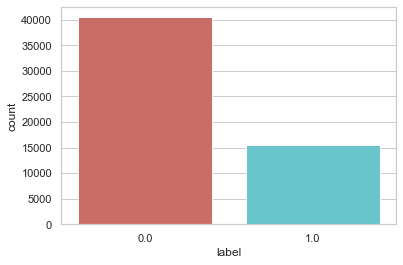

In [25]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
df = pd.concat([X_train, y_train], axis=1)
y_data = pd.DataFrame(df['label'])
sns.countplot(x='label', data=y_data, palette='hls')
plt.show()

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

C:\Users\ruzks\AppData\Local\Temp\ipykernel_13192\3725724126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=y_data, palette='hls')


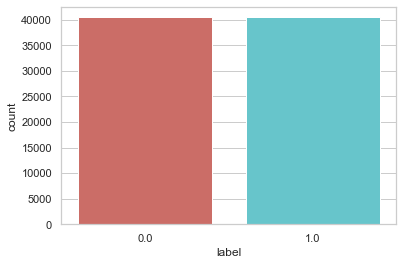

In [27]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
df = pd.concat([X_train_balanced, y_train_balanced], axis=1)
y_data = pd.DataFrame(df['label'])
sns.countplot(x='label', data=y_data, palette='hls')
plt.show()

In [28]:
model = LogisticRegression()
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

C:\Users\ruzks\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred)}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_prob)}')

Accuracy: 0.7995328272294986
Precision: 0.6022777532065458
Recall: 0.818359375
F1-score: 0.6938853503184713
ROC-AUC: 0.8883725393821014


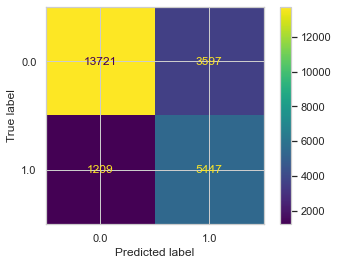

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot();

## Сохранение модели

In [31]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(model,f)
f.close()